# Proseq Gene body Expression Value Prediction prototype

In [1]:
import argparse
from models import *
from utils.plot_utils import *
from utils.metrics_utils import *
from utils.train_utils import *
import horovod.tensorflow.keras as hvd
import time
import pyBigWig
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, \
    cohen_kappa_score, auc, roc_curve, matthews_corrcoef, precision_recall_curve, roc_auc_score, average_precision_score

In [2]:
f_length = 1000

In [3]:
# def generate_data_batch(file_path='./'):

file_path=''

path1 = file_path+'./data/dna_bigwig/'  # dna
path2 = file_path+'./data/atac_bigwig/'  # atac
path3 = file_path+'./data/PRO-seq_bed_files/Proseq_genebody_expr_'+ str(f_length) + '_flanking.bed'

# open bigwig
list_dna = ['A', 'C', 'G', 'T']
dict_dna = {}
for the_id in list_dna:
    dict_dna[the_id] = pyBigWig.open(path1 + the_id + '.bigwig')

num_bp = np.array([23513712, 25286936, 28110227, 32079331, 1348131, 23542271, 3667352])
chr_all = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']

chr_len = {}
for i in np.arange(len(chr_all)):
    chr_len[chr_all[i]] = num_bp[i]

size = f_length*2  
num_channel = 5

genome_seq_batch = []
label_batch = []

feature_bw = pyBigWig.open(path2 + 'wt-ATAC.1x.P9108.bw')
exp_bed = open(path3, 'r')

for idx, line in enumerate(exp_bed):

    # ignore header
    if idx == 0:
        continue
    bed_record = line.split("\t")
    the_chr = bed_record[0]
    start = int(bed_record[1])
    end = int(bed_record[2])
    exp = float(bed_record[-1])

    # ignore chrom not in the chrom list
    if the_chr not in chr_all:
        continue

    if abs(start - end) != size:
        print("start - end != flanking_region_len")
        continue

    genome_seq = np.zeros((num_channel, size))
    num = 0
    for k in np.arange(len(list_dna)):
        the_id = list_dna[k]
        genome_seq[num, :] = dict_dna[the_id].values(the_chr, start, end)
        num += 1
    genome_seq[num, :] = np.nan_to_num(np.array(feature_bw.values(the_chr, start, end)), nan=0.0)
    
    # genome_seq[num+1, :] = np.nan_to_num(np.array(feature2_bw.values(the_chr, start, end)), nan=0.0)

    genome_seq_batch.append(genome_seq.T)
    label_batch.append(exp)

feature_bw.close()
exp_bed.close()

start - end != flanking_region_len


In [4]:
np.array(label_batch).shape, np.array(genome_seq_batch).shape

((12658,), (12658, 2000, 5))

In [5]:
max(np.round(label_batch)),min(np.round(label_batch))

(13.0, -3.0)

In [6]:
multi_model = tf.keras.models.load_model("./output/multi_2.5.fimo_labels_trans_unet_output/model/", custom_objects={'dice_coef':dice_coef, 'f1_metrics':f1_metrics,'matthews_correlation_coefficient':matthews_correlation_coefficient})

2022-10-18 16:52:57.922441: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 16:53:00.960513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


In [7]:
model_input = multi_model.layers[0].output
x = multi_model.layers[-2].output 
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
gene_body_prediction = Dense(1, activation='linear')(x)
model = Model(inputs = model_input, outputs = gene_body_prediction)
# model.summary()

In [9]:
full_dataset = tf.data.Dataset.from_tensor_slices((genome_seq_batch, np.round(label_batch)))

DATASET_SIZE = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
print(train_size, val_size, test_size)

full_dataset = full_dataset.shuffle(50000, reshuffle_each_iteration=False)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

batch_size = 100
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Disable AutoShard for multi GPUs support
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_dataset = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

8860 1898 1898


In [10]:
opt = tf.optimizers.Adam()


# model = Exp_Trans_UNet(input_size=(max_len, vocab_size))
r_square = tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(1,))
rmse = tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=opt,
              loss=tf.keras.losses.mean_squared_error,
              metrics=[r_square, rmse])

scheduler = CosineScheduler(max_update=100, base_lr=0.001, final_lr=0.0001, warmup_steps=15, warmup_begin_lr=0.0001)
# scheduler = CosineScheduler(max_update=100, base_lr=0.0005*hvd.size(), final_lr=0.00001*hvd.size(), warmup_steps=20, warmup_begin_lr=0.00001)
learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [learning_rate,early_stop]

In [11]:
history = model.fit(x=train_dataset, epochs=200,validation_data=val_dataset, callbacks=callbacks)

Epoch 1/200


2022-10-18 16:54:07.880880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


89/89 [==============================] - 73s 624ms/step - loss: 33.6757 - r_square: -3.0768 - root_mean_squared_error: 5.8031 - val_loss: 5.4707 - val_r_square: 0.3645 - val_root_mean_squared_error: 2.3390 - lr: 1.0000e-04
Epoch 2/200
89/89 [==============================] - 53s 597ms/step - loss: 4.6549 - r_square: 0.4365 - root_mean_squared_error: 2.1575 - val_loss: 4.6201 - val_r_square: 0.4633 - val_root_mean_squared_error: 2.1495 - lr: 1.6000e-04
Epoch 3/200
89/89 [==============================] - 53s 596ms/step - loss: 4.2269 - r_square: 0.4883 - root_mean_squared_error: 2.0559 - val_loss: 4.4985 - val_r_square: 0.4774 - val_root_mean_squared_error: 2.1210 - lr: 2.2000e-04
Epoch 4/200
89/89 [==============================] - 53s 595ms/step - loss: 3.7963 - r_square: 0.5404 - root_mean_squared_error: 1.9484 - val_loss: 43.4610 - val_r_square: -4.0488 - val_root_mean_squared_error: 6.5925 - lr: 2.8000e-04
Epoch 5/200
89/89 [==============================] - 53s 596ms/step - loss: 

In [13]:
model.evaluate(test_dataset)

19/19 [==============================] - 5s 214ms/step - loss: 3.7576 - r_square: 0.5620 - root_mean_squared_error: 1.9385


[3.757646083831787, 0.5619932413101196, 1.938464879989624]

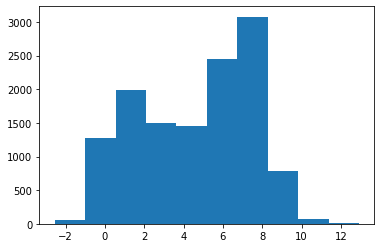

In [14]:
n_classes = 10
plt.hist(label_batch, bins = n_classes)
plt.show()

In [15]:
pred_pi = model.predict(test_dataset)

true_pi = []
tmp_dataset = test_dataset.unbatch()
for _, true_test_label in tmp_dataset.as_numpy_iterator():
    true_pi.append(true_test_label)

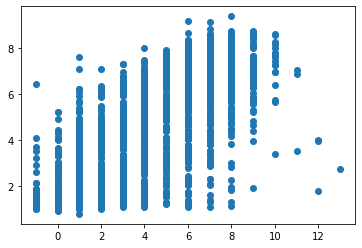

In [16]:
plt.scatter(true_pi, pred_pi)

In [17]:
n_classes = 2
bin_counts, bin_edges = np.histogram(label_batch, bins=n_classes)
bin_counts, bin_edges

(array([6258, 6400]), array([-2.55583257,  5.18345443, 12.92274142]))

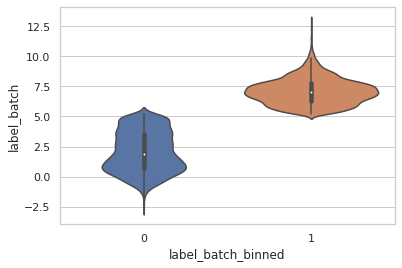

In [18]:
label_batch_binned = []
# for i in label_batch:
#     if i < bin_edges[1]:
#         label_batch_binned.append(0)
#     elif bin_edges[1] <= i < bin_edges[2]:
#         label_batch_binned.append(1)
#     else:
#         label_batch_binned.append(2)
for i in label_batch:
    if i < bin_edges[1]:
        label_batch_binned.append(0)
    else:
        label_batch_binned.append(1)

import pandas as pd
import seaborn as sns
df = pd.DataFrame({'label_batch_binned':label_batch_binned, 'label_batch': label_batch})
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="label_batch_binned", y="label_batch", data=df)

In [24]:
full_dataset = tf.data.Dataset.from_tensor_slices((genome_seq_batch, label_batch_binned))

DATASET_SIZE = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
print(train_size, val_size, test_size)

full_dataset = full_dataset.shuffle(50000, reshuffle_each_iteration=False)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

batch_size = 200
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Disable AutoShard for multi GPUs support
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_dataset = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

8860 1898 1898


In [25]:
model_input = multi_model.layers[0].output
x = multi_model.layers[-2].output 
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
gene_body_prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_input, outputs = gene_body_prediction)
# model.summary()

In [26]:
opt = tf.optimizers.Adam()

# model = Exp_Trans_UNet(input_size=(max_len, vocab_size))
r_square = tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(1,))
rmse = tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=opt,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy',
                       tf.keras.metrics.AUC(curve="ROC", num_thresholds=1001, name="auc"),
                       tf.keras.metrics.AUC(curve="PR", num_thresholds=1001, name="pr_auc")])

scheduler = CosineScheduler(max_update=100, base_lr=0.001, final_lr=0.0001, warmup_steps=15, warmup_begin_lr=0.0001)
learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [learning_rate,early_stop]

In [27]:
history = model.fit(x=train_dataset, epochs=200,validation_data=val_dataset, callbacks=callbacks)

Epoch 1/200
45/45 [==============================] - 64s 1s/step - loss: 1.6655 - accuracy: 0.6558 - auc: 0.6658 - pr_auc: 0.6247 - val_loss: 0.4330 - val_accuracy: 0.8032 - val_auc: 0.8863 - val_pr_auc: 0.8861 - lr: 1.0000e-04
Epoch 2/200
45/45 [==============================] - 49s 1s/step - loss: 0.4227 - accuracy: 0.8188 - auc: 0.8881 - pr_auc: 0.8885 - val_loss: 0.4217 - val_accuracy: 0.8216 - val_auc: 0.8966 - val_pr_auc: 0.9042 - lr: 1.6000e-04
Epoch 3/200
45/45 [==============================] - 49s 1s/step - loss: 0.4128 - accuracy: 0.8219 - auc: 0.8933 - pr_auc: 0.8968 - val_loss: 0.4349 - val_accuracy: 0.8137 - val_auc: 0.8845 - val_pr_auc: 0.9022 - lr: 2.2000e-04
Epoch 4/200
45/45 [==============================] - 49s 1s/step - loss: 0.4040 - accuracy: 0.8260 - auc: 0.8978 - pr_auc: 0.9026 - val_loss: 0.4154 - val_accuracy: 0.8174 - val_auc: 0.8933 - val_pr_auc: 0.9067 - lr: 2.8000e-04
Epoch 5/200
45/45 [==============================] - 49s 1s/step - loss: 0.4047 - accura

In [50]:
model.save("PRO_seq_model/")

2022-10-18 17:53:52.977653: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: PRO_seq_model/assets


INFO:tensorflow:Assets written to: PRO_seq_model/assets


In [28]:
pred_exp = model.predict(test_dataset)

true_exp = []
tmp_dataset = test_dataset.unbatch()
for _, true_test_label in tmp_dataset.as_numpy_iterator():
    true_exp.append(true_test_label)
    
decoded_pred_exp = np.round(pred_exp)
decoded_true_exp = true_exp

print('f1_score: ', f1_score(decoded_true_exp, decoded_pred_exp, average='weighted'))
print('matthews_corrcoef: ', matthews_corrcoef(decoded_true_exp, decoded_pred_exp))
print('roc_auc_score: ',roc_auc_score(true_exp, pred_exp))
print('average_precision_score: ',average_precision_score(true_exp, pred_exp))
print('precision_score: ', precision_score(true_exp, np.round(pred_exp),average='weighted'))
print('recall_score: ', recall_score(true_exp, np.round(pred_exp),average='weighted'))
print('accuracy_score: ', accuracy_score(true_exp, np.round(pred_exp)))

f1_score:  0.8213086736766247
matthews_corrcoef:  0.6455896724803288
roc_auc_score:  0.9046234551435939
average_precision_score:  0.909126648763333
precision_score:  0.8240799385145462
recall_score:  0.821390937829294
accuracy_score:  0.821390937829294


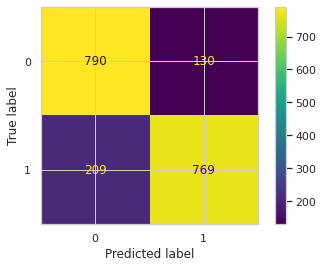

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(decoded_true_exp, decoded_pred_exp)
cm_display = ConfusionMatrixDisplay(cm).plot()

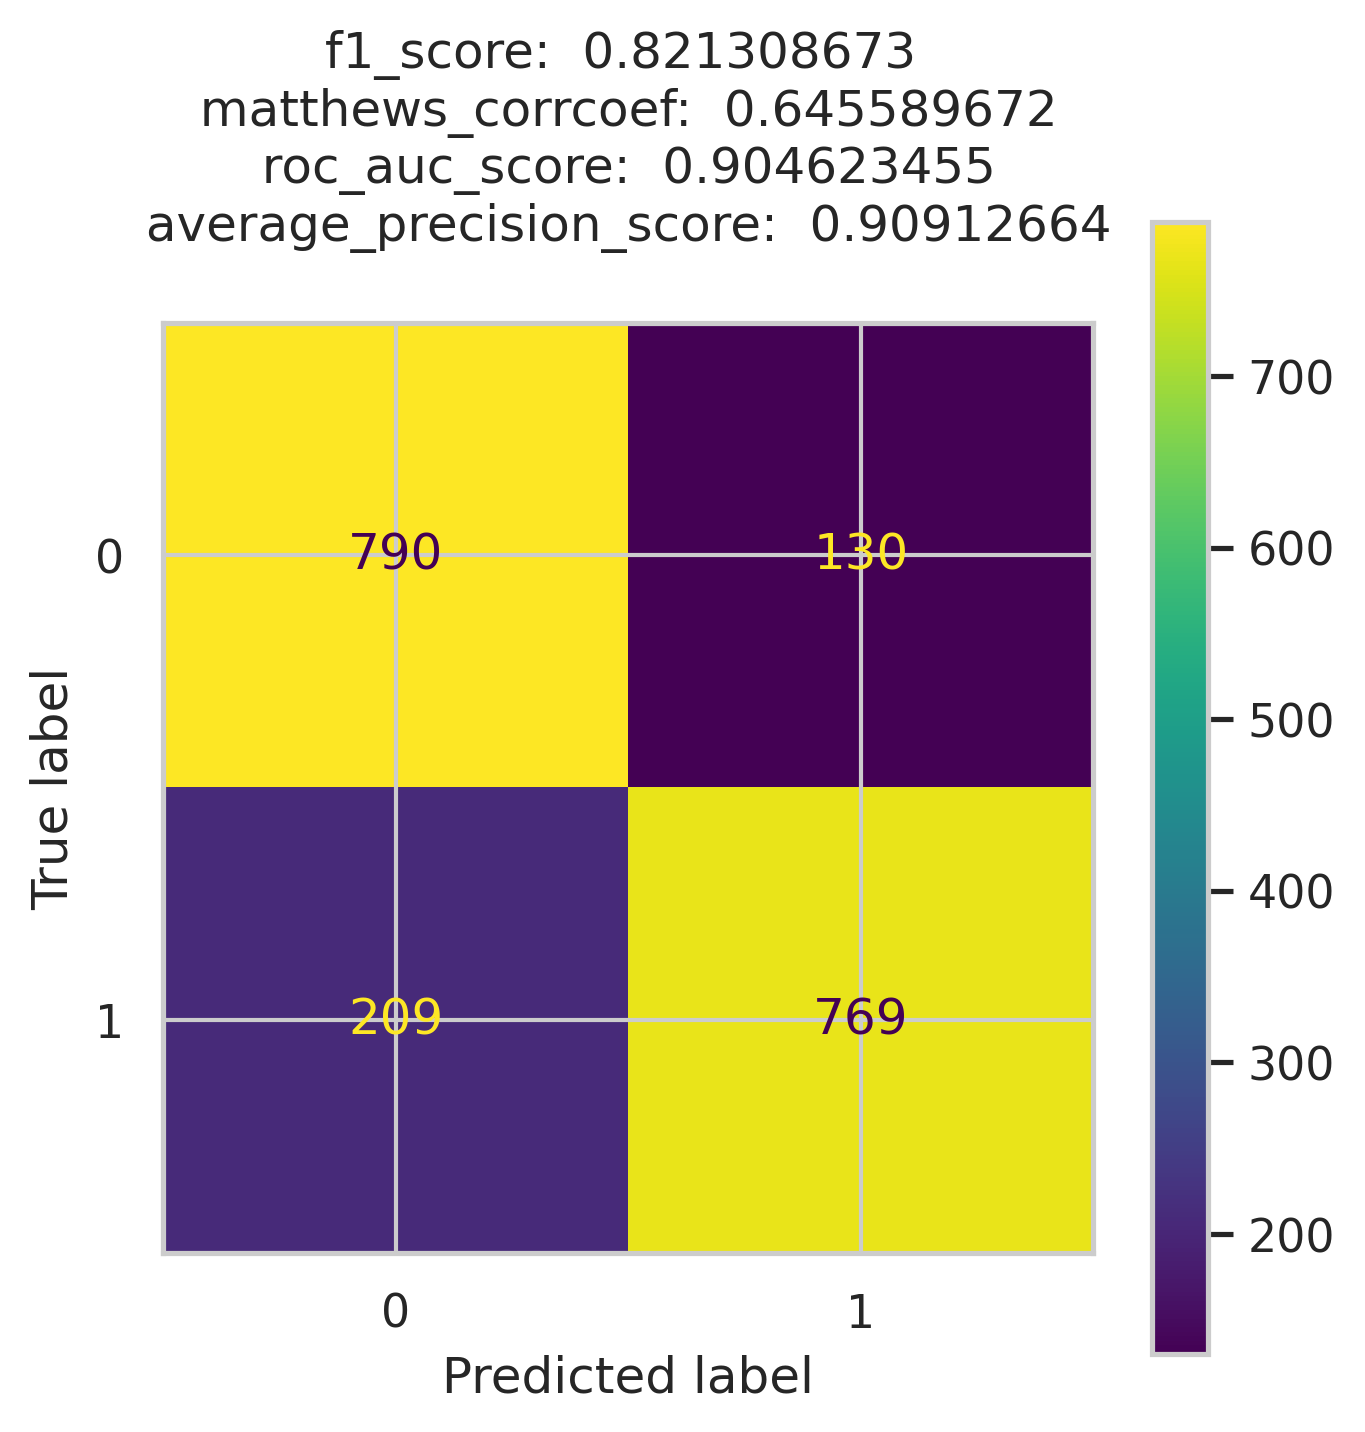

In [49]:
fig, ax = plt.subplots(figsize=(5,5),dpi= 300, facecolor='w', edgecolor='k')
cm_display.plot(ax=ax)
ax.set_title(f"f1_score:  0.821308673 \n matthews_corrcoef:  0.645589672 \n roc_auc_score:  0.904623455 \n average_precision_score:  0.90912664 \n")
plt.savefig("PRO_seq_Confusion_Matrix.svg")
plt.show()

In [6]:
def Exp_Trans_UNet(input_size=(2000, 5), n_filters=32, n_head = 8, n_ff_dims = 64, n_classes=1):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)
    max_len, vocab_size = input_size
    dropout_prob = 0.2
    kernel_size = 9
    num_heads = 12
    
    cblock1 = EncoderSeTBlock(inputs, pos_len=2000, num_heads=0, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_1_", max_pooling=True)
    cblock2 = EncoderSeTBlock(cblock1[0], pos_len=1000, num_heads=0, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_2_", max_pooling=True)
    cblock3 = EncoderSeTBlock(cblock2[0], pos_len=500, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_3_", max_pooling=True)
    cblock4 = EncoderSeTBlock(cblock3[0], pos_len=250, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_4_", max_pooling=True)
    cblock5 = EncoderSeTBlock(cblock4[0], pos_len=125, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_5_", max_pooling=False)

    ublock6 = DecoderSeTBlock(cblock5[0], cblock4[1],  pos_len=250, num_heads=num_heads, kernel_size=kernel_size, n_filters=256, layer_name="dcb_1_")
    ublock7 = DecoderSeTBlock(ublock6, cblock3[1], pos_len=500, num_heads=num_heads, kernel_size=kernel_size, n_filters=256, layer_name="dcb_2_")
    ublock8 = DecoderSeTBlock(ublock7, cblock2[1], pos_len=1000, num_heads=0, kernel_size=kernel_size, n_filters=256, layer_name="dcb_3_")
    ublock9 = DecoderSeTBlock(ublock8, cblock1[1], pos_len=2000, num_heads=0, kernel_size=kernel_size, n_filters=256, layer_name="dcb_4_")
    
    conv9_0 = Conv1D(filters=128,
                   kernel_size=11,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)
    x = SqueezeExcitation1DLayer(out_dim=128, ratio=8, layer_name='se_0')(conv9_0)
    conv9_1 = Conv1D(filters=64,
                   kernel_size=7,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(x)
    x = SqueezeExcitation1DLayer(out_dim=64, ratio=8, layer_name='se_1')(conv9_1)
    conv9_2 = Conv1D(filters=32,
                   kernel_size=3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(x)
    x = SqueezeExcitation1DLayer(out_dim=32, ratio=8, layer_name='se_2')(conv9_2)
    flatten = Flatten()(x)
    dense1_0 = Dense(32, activation='relu')(flatten)
    dense1_1 = Dense(16, activation='relu')(dense1_0)
    dense1_2 = Dense(n_classes, activation='linear')(dense1_1)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=dense1_2)

    return model

In [7]:
max_len=f_length*2
vocab_size=5
num_gpus = len(tf.config.list_physical_devices('GPU'))
opt = tf.optimizers.Adam()

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = Exp_Trans_UNet(input_size=(max_len, vocab_size))
    r_square = tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(1,))
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=[r_square, rmse])

scheduler = CosineScheduler(max_update=100, base_lr=0.001*num_gpus, final_lr=0.0001*num_gpus, warmup_steps=15, warmup_begin_lr=0.0001)
# scheduler = CosineScheduler(max_update=100, base_lr=0.0005*hvd.size(), final_lr=0.00001*hvd.size(), warmup_steps=20, warmup_begin_lr=0.00001)
learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [learning_rate,early_stop]

2022-10-05 11:59:42.836068: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 11:59:46.697401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

## round the expression to integer (caution with negative value)

In [8]:
full_dataset = tf.data.Dataset.from_tensor_slices((genome_seq_batch, np.round(label_batch)))

DATASET_SIZE = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
print(train_size, val_size, test_size)

full_dataset = full_dataset.shuffle(50000, reshuffle_each_iteration=False)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

batch_size = 100
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Disable AutoShard for multi GPUs support
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_dataset = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

8860 1898 1898


In [ ]:
history = model.fit(x=train_dataset, epochs=200,validation_data=val_dataset, callbacks=callbacks)

Epoch 1/200


2022-10-05 12:00:28.564410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


89/89 [==============================] - 55s 412ms/step - loss: 5.4896 - r_square: 0.3386 - root_mean_squared_error: 2.3430 - val_loss: 18.4767 - val_r_square: -1.1741 - val_root_mean_squared_error: 4.2985 - lr: 1.0000e-04
Epoch 2/200
89/89 [==============================] - 33s 367ms/step - loss: 3.9964 - r_square: 0.5185 - root_mean_squared_error: 1.9991 - val_loss: 16.3714 - val_r_square: -0.9263 - val_root_mean_squared_error: 4.0462 - lr: 1.6000e-04
Epoch 3/200
89/89 [==============================] - 33s 367ms/step - loss: 3.9056 - r_square: 0.5294 - root_mean_squared_error: 1.9763 - val_loss: 4.8971 - val_r_square: 0.4238 - val_root_mean_squared_error: 2.2129 - lr: 2.2000e-04
Epoch 4/200
89/89 [==============================] - 33s 366ms/step - loss: 3.8945 - r_square: 0.5308 - root_mean_squared_error: 1.9735 - val_loss: 5.2721 - val_r_square: 0.3797 - val_root_mean_squared_error: 2.2961 - lr: 2.8000e-04
Epoch 5/200
89/89 [==============================] - 33s 368ms/step - loss: 

In [ ]:
model.evaluate(test_dataset)

In [ ]:
n_classes = 10
plt.hist(label_batch, bins = n_classes)
plt.show()

In [17]:
pred_pi = model.predict(test_dataset)

true_pi = []
tmp_dataset = test_dataset.unbatch()
for _, true_test_label in tmp_dataset.as_numpy_iterator():
    true_pi.append(true_test_label)

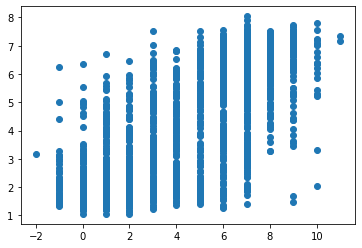

In [18]:
plt.scatter(true_pi, pred_pi)

# binary classification

In [7]:
def Exp_Trans_UNet(input_size=(2000, 5), n_filters=32, n_head = 8, n_ff_dims = 64, n_classes=1):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)
    max_len, vocab_size = input_size
    dropout_prob = 0.2
    kernel_size = 9
    num_heads = 0
    
    cblock1 = EncoderSeTBlock(inputs, pos_len=200, num_heads=0, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_1_", max_pooling=True)
    cblock2 = EncoderSeTBlock(cblock1[0], pos_len=100, num_heads=0, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_2_", max_pooling=True)
    cblock3 = EncoderSeTBlock(cblock2[0], pos_len=50, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_3_", max_pooling=True)
    cblock4 = EncoderSeTBlock(cblock3[0], pos_len=25, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_4_", max_pooling=False)
    # cblock5 = EncoderSeTBlock(cblock4[0], pos_len=125, num_heads=num_heads, n_filters=32, kernel_size=kernel_size, dropout_prob=dropout_prob, layer_name="ecb_5_", max_pooling=False)

    # ublock6 = DecoderSeTBlock(cblock5[0], cblock4[1],  pos_len=25, num_heads=num_heads, kernel_size=kernel_size, n_filters=256, layer_name="dcb_1_")
    ublock7 = DecoderSeTBlock(cblock4[0], cblock3[1], pos_len=50, num_heads=num_heads, kernel_size=kernel_size, n_filters=256, layer_name="dcb_2_")
    ublock8 = DecoderSeTBlock(ublock7, cblock2[1], pos_len=100, num_heads=0, kernel_size=kernel_size, n_filters=256, layer_name="dcb_3_")
    ublock9 = DecoderSeTBlock(ublock8, cblock1[1], pos_len=200, num_heads=0, kernel_size=kernel_size, n_filters=256, layer_name="dcb_4_")
    
    conv9_0 = Conv1D(filters=128,
                   kernel_size=11,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)
    x = SqueezeExcitation1DLayer(out_dim=128, ratio=8, layer_name='se_0')(conv9_0)
    conv9_1 = Conv1D(filters=64,
                   kernel_size=7,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(x)
    x = SqueezeExcitation1DLayer(out_dim=64, ratio=8, layer_name='se_1')(conv9_1)
    conv9_2 = Conv1D(filters=32,
                   kernel_size=3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(x)
    x = SqueezeExcitation1DLayer(out_dim=32, ratio=8, layer_name='se_2')(conv9_2)
    flatten = Flatten()(x)
    dense1_0 = Dense(32, activation='relu')(flatten)
    dense1_1 = Dense(16, activation='relu')(dense1_0)
    dense1_2 = Dense(n_classes, activation='sigmoid')(dense1_1)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=dense1_2)

    return model

def rnn_model(input_shape=(200,5)):
    model = Sequential([
          InputLayer(input_shape=input_shape),
          Bidirectional(LSTM(64, return_sequences = True), input_shape=input_shape),
          Dropout(0.2),
          Bidirectional(LSTM(32)),
          Dropout(0.2),
          Dense(64,activation='relu'),
          Dropout(0.2),
          Dense(32,activation='relu'),
          Dense(16,activation='relu'),
          Dense(1, activation='sigmoid')
        ])  
    return model

In [8]:
n_classes = 2
bin_counts, bin_edges = np.histogram(label_batch, bins=n_classes)
bin_counts, bin_edges

(array([6258, 6400]), array([-2.55583257,  5.18345443, 12.92274142]))

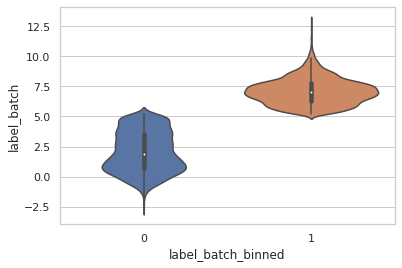

In [13]:
label_batch_binned = []
# for i in label_batch:
#     if i < bin_edges[1]:
#         label_batch_binned.append(0)
#     elif bin_edges[1] <= i < bin_edges[2]:
#         label_batch_binned.append(1)
#     else:
#         label_batch_binned.append(2)
for i in label_batch:
    if i < bin_edges[1]:
        label_batch_binned.append(0)
    else:
        label_batch_binned.append(1)

import pandas as pd
import seaborn as sns
df = pd.DataFrame({'label_batch_binned':label_batch_binned, 'label_batch': label_batch})
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="label_batch_binned", y="label_batch", data=df)

In [14]:
full_dataset = tf.data.Dataset.from_tensor_slices((genome_seq_batch, label_batch_binned))

DATASET_SIZE = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
print(train_size, val_size, test_size)

full_dataset = full_dataset.shuffle(50000, reshuffle_each_iteration=False)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

batch_size = 100
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Disable AutoShard for multi GPUs support
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_dataset = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

8860 1898 1898


In [15]:
max_len=f_length*2
vocab_size=5

opt = tf.optimizers.Adam()

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = Exp_Trans_UNet(input_size=(max_len, vocab_size))
    # model = rnn_model(input_shape=(max_len, vocab_size))
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(curve="ROC", num_thresholds=1001, name="auc"),
                           tf.keras.metrics.AUC(curve="PR", num_thresholds=1001, name="pr_auc")])

scheduler = CosineScheduler(max_update=100, base_lr=0.001*num_gpus, final_lr=0.0001*num_gpus, warmup_steps=15, warmup_begin_lr=0.0001)
# scheduler = CosineScheduler(max_update=100, base_lr=0.0005*hvd.size(), final_lr=0.00001*hvd.size(), warmup_steps=20, warmup_begin_lr=0.00001)
learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [learning_rate,early_stop]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [16]:
history = model.fit(x=train_dataset, epochs=200,validation_data=val_dataset, callbacks=callbacks)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 142 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 142 all-reduces with algorithm = nccl, num_packs = 1


2022-09-09 12:01:31.248498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2022-09-09 12:01:32.210885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


89/89 [==============================] - 41s 248ms/step - loss: 0.5027 - accuracy: 0.7526 - auc: 0.8381 - pr_auc: 0.8430 - val_loss: 0.6706 - val_accuracy: 0.6511 - val_auc: 0.8617 - val_pr_auc: 0.8585 - lr: 1.0000e-04
Epoch 2/200
89/89 [==============================] - 19s 209ms/step - loss: 0.4450 - accuracy: 0.8060 - auc: 0.8749 - pr_auc: 0.8748 - val_loss: 0.6680 - val_accuracy: 0.4858 - val_auc: 0.8090 - val_pr_auc: 0.8306 - lr: 2.2667e-04
Epoch 3/200
89/89 [==============================] - 19s 209ms/step - loss: 0.4399 - accuracy: 0.8078 - auc: 0.8784 - pr_auc: 0.8809 - val_loss: 0.6642 - val_accuracy: 0.7616 - val_auc: 0.8159 - val_pr_auc: 0.8396 - lr: 3.5333e-04
Epoch 4/200
89/89 [==============================] - 19s 209ms/step - loss: 0.4349 - accuracy: 0.8107 - auc: 0.8818 - pr_auc: 0.8809 - val_loss: 0.6091 - val_accuracy: 0.7863 - val_auc: 0.8108 - val_pr_auc: 0.8429 - lr: 4.8000e-04
Epoch 5/200
89/89 [==============================] - 19s 209ms/step - loss: 0.4271 - acc

In [17]:
pred_exp = model.predict(test_dataset)

true_exp = []
tmp_dataset = test_dataset.unbatch()
for _, true_test_label in tmp_dataset.as_numpy_iterator():
    true_exp.append(true_test_label)
    
decoded_pred_exp = np.round(pred_exp)
decoded_true_exp = true_exp

print('f1_score: ', f1_score(decoded_true_exp, decoded_pred_exp, average='weighted'))
print('matthews_corrcoef: ', matthews_corrcoef(decoded_true_exp, decoded_pred_exp))
print('roc_auc_score: ',roc_auc_score(true_exp, pred_exp))
print('average_precision_score: ',average_precision_score(true_exp, pred_exp))
print('precision_score: ', precision_score(true_exp, np.round(pred_exp),average='weighted'))
print('recall_score: ', recall_score(true_exp, np.round(pred_exp),average='weighted'))
print('accuracy_score: ', accuracy_score(true_exp, np.round(pred_exp)))

f1_score:  0.8265044985248678
matthews_corrcoef:  0.6576124093269815
roc_auc_score:  0.8947497903581405
average_precision_score:  0.8985798450726552
precision_score:  0.8308553047183804
recall_score:  0.827186512118019
accuracy_score:  0.827186512118019


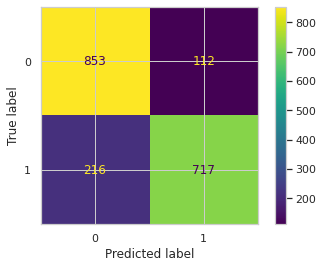

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(decoded_true_exp, decoded_pred_exp)
cm_display = ConfusionMatrixDisplay(cm).plot()